In [26]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import MatrixProductFunctions as mp
import os
import cmath
from numba import njit
import matplotlib.animation as animation
import math
from ipywidgets import IntProgress, HTML
from IPython.display import display
import pickle
import sys
from multiprocessing import Process
from IPython.display import display, clear_output
import scipy.optimize as optimize
from scipy.sparse import csr_matrix, kron
from scipy.sparse.linalg import spsolve
import sparse
import scipy

### Гамильтониан вырожденного спонтанного параметрического рассеяния DSPDC

#### $H_{spdc} = i\hbar \chi^{(2)}(\hat{a}^{\dagger}\hat{b}\hat{b} - \hat{a}\hat{b}^{\dagger}\hat{b}^{\dagger})$

### уравнение эволюции

$(1 + i\Delta t \hat{H})\psi_{t+1} = \psi_t$

#### Оператор уничтожения фотона в фоковском базисе

$\hat{a} = 
\
\begin{pmatrix}
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & \sqrt{2} & 0 & 0 & 0 \\
0 & 0 & 0 & \sqrt{3} & 0 & 0 \\
0 & 0 & 0 & 0 & \sqrt{4} & 0  \\
0 & 0 & 0 & 0 & 0 & \sqrt{5} \\
0 & 0 & 0 & 0 & 0 & 0 \\
\end{pmatrix}
$

In [27]:
def annihilate_photon(n):
    A = np.zeros((n, n))
    for i in range(len(A)-1):
        A[i][i+1] = np.sqrt(i+1)
    return A

#### Оператор рождения фотона в фоковском базисе

$\hat{a}^{\dagger} = 
\
\begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 & 0 & 0 & \\
0 & \sqrt{2} & 0 & 0 & 0 & 0 \\
0 & 0 & \sqrt{3} & 0 & 0 & 0 \\
0 & 0 & 0 & \sqrt{4} & 0 & 0 \\
0 & 0 & 0 & 0 & \sqrt{5} & 0 \\
\end{pmatrix}
$

In [28]:
def create_photon(n):
    A = np.zeros((n, n))
    for i in range(1, len(A)):
        A[i][i-1] = np.sqrt(i)
    return A

## Расчеты SPDC без использования разреженных матриц

### Параметры

In [29]:
n_pump = 150
n_signal = 1000
alpha = 10
t_general = 1
steps_number = 100000
delta_t = t_general/steps_number
chi = 0.5

### Сохранение параметров

In [30]:
# with open('C:/Users/kaprn/Desktop/MPS_directory/TensorNetworks/Tests_of_spdc/Data_for_article/alpha_20_comparison/solutions_for_Fock_basis_alpha_10_photon_dynamics_#3_100000_steps.txt', 'w') as file:
#     file.write(f"t_general={t_general}\n")
#     file.write(f"n_pump={n_pump}\n")
#     file.write(f"n_signal={n_signal}\n")
#     file.write(f"steps_number={steps_number}\n")
#     file.write(f"delta_t={delta_t}\n")
#     file.write(f"chi={chi}\n")     

### Гамильтониан SPDC

In [31]:
# hamiltonian_part_1 = np.einsum("ab, cd -> acbd", create_photon(n_pump), annihilate_photon(n_signal) @ annihilate_photon(n_signal))
# shape = hamiltonian_part_1.shape
# hamiltonian_part_1 = hamiltonian_part_1.reshape(shape[0]*shape[1], shape[2]*shape[3])

# hamiltonian_part_2 = np.einsum("ab, cd -> acbd", annihilate_photon(n_pump), create_photon(n_signal) @ create_photon(n_signal))
# shape = hamiltonian_part_2.shape
# hamiltonian_part_2 = hamiltonian_part_2.reshape(shape[0]*shape[1], shape[2]*shape[3])

# full_hamiltonian = 1j*chi*(hamiltonian_part_1 - hamiltonian_part_2)

#### Гамильтониан SPDC (приготовление сразу в разреженном виде)

In [32]:
hamiltonian_part_1 = kron(csr_matrix(create_photon(n_pump)), csr_matrix(annihilate_photon(n_signal) @ annihilate_photon(n_signal)))
hamiltonian_part_2 = kron(csr_matrix(annihilate_photon(n_pump)), csr_matrix(create_photon(n_signal) @ create_photon(n_signal)))
full_hamiltonian = 1j*chi*(hamiltonian_part_1 - hamiltonian_part_2)

In [33]:
full_hamiltonian

<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 297404 stored elements and shape (150000, 150000)>

### Оператор эволюции

In [34]:
evolution_operator_csr = kron(csr_matrix(np.eye(n_pump)), csr_matrix(np.eye(n_signal))) + 1j*delta_t*full_hamiltonian

### Определение состояний

#### Функция генерации Фоковского состояния (вектор в Фоковском базисе)

In [35]:
def get_Fock_state(n, number_of_photons):
    state = np.zeros(n)
    state[number_of_photons] = 1
    return state

#### Функция генерации когерентного состояния (вектор в Фоковском базисе)

$|\alpha \rangle = \exp(-\dfrac{1}{2}|\alpha|^2)\sum_{n=0}^{\infty}(\dfrac{\alpha^n}{\sqrt{n!}}) |n \rangle$

In [36]:
def get_Coherent_state(n, alpha):
    
    def exponenta(alpha,i):
        summa = 0
        for j in range(1,i+1):
            summa += np.log(j)
        return np.exp(-(abs(alpha))**2 / 2 - 1 / 2 * summa + i * np.log(alpha))  

    state = np.ones(n)
    for i in range(len(state)):
        state[i] = state[i]*exponenta(alpha, i)
    return state

#### Оператор числа фотонов

In [37]:
def get_photon_number_operator(n):
    matrix = np.zeros((n,n))
    for i in range(len(matrix)):
        matrix[i][i] = i
    return matrix

#### Вакуумное состояние

In [38]:
vacuum_state = get_Fock_state(n_signal, 0)

#### Статистика фотонов в вакуумном состоянии

Text(0.5, 0, 'Номер фоковского состояния')

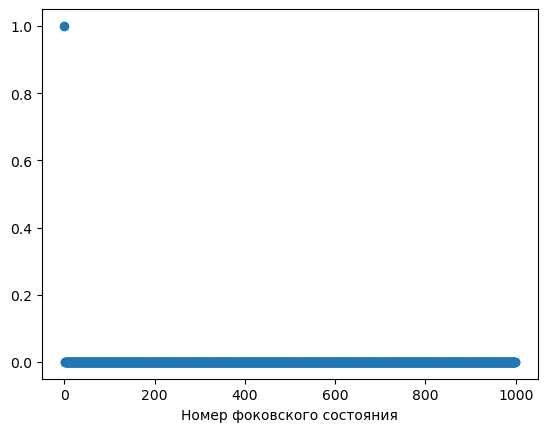

In [39]:
plt.scatter(np.arange(len(vacuum_state)), vacuum_state)
plt.xlabel("Номер фоковского состояния")

#### Матрица плотности вакуумного состояния

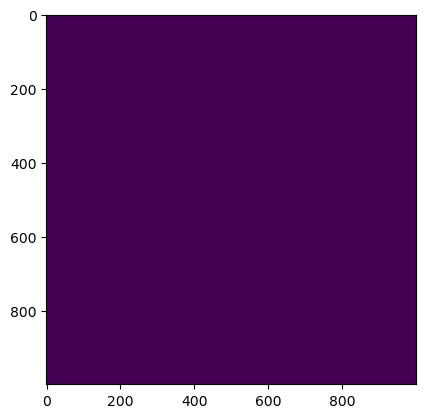

In [40]:
plt.imshow(np.outer(vacuum_state, np.conj(vacuum_state)))

#### Когерентное состояние

In [41]:
coherent_state = get_Coherent_state(n_pump,alpha)

#### Статистика фотонов в когерентном состоянии

Text(0.5, 0, 'Номер фоковского состояния')

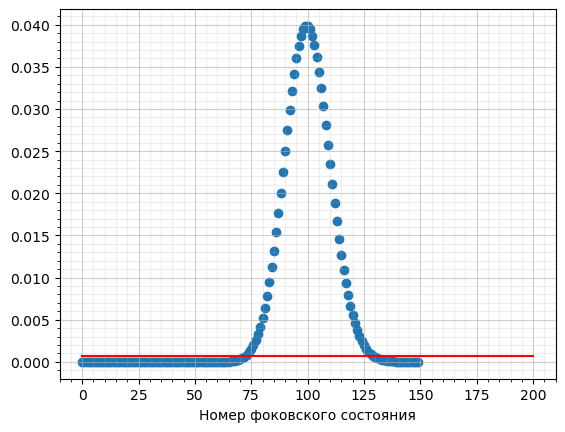

In [42]:
#plt.scatter(np.arange(len(coherent_state1)), coherent_state1)
plt.scatter(np.arange(len(coherent_state)), coherent_state**2)
plt.plot(np.linspace(0,200,10), 0.04/(math.e**4)*np.ones(10), color = "red")
plt.grid(which = 'major', alpha = 0.6)
plt.grid(which = 'minor', alpha = 0.2)
plt.minorticks_on()
plt.xlabel("Номер фоковского состояния")

In [45]:
coherent_state**2 @ np.arange(150), coherent_state**2 @ (np.arange(150)-coherent_state**2 @ np.arange(150))**2

(np.float64(99.99971391154085), np.float64(99.99492823456151))

In [20]:
0.04/math.e, 20*np.sqrt(2), 1/(0.04*np.sqrt(2*np.pi)), np.sqrt(8)

(0.014715177646857694,
 np.float64(28.284271247461902),
 np.float64(9.973557010035819),
 np.float64(2.8284271247461903))

In [21]:
r = np.log(4*13400)/2
r = 2.45

In [22]:
np.sqrt(2)*(math.cosh(r)*math.sinh(r))

np.float64(47.47597416493963)

#### Матрица плотности когерентного состояния

99.99971391154085


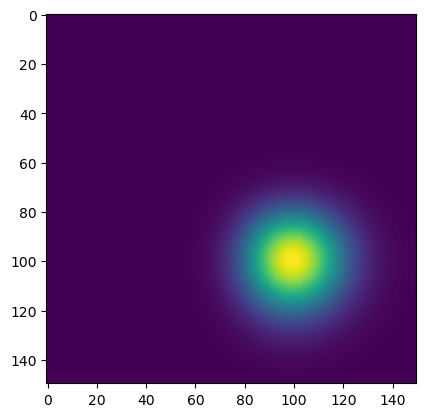

In [293]:
plt.imshow(np.outer(coherent_state, np.conj(coherent_state)))
print(np.trace(np.real(np.outer(coherent_state, np.conj(coherent_state)))@get_photon_number_operator(n_pump)))

#### Общее состояние

In [294]:
common_state = np.einsum("a, b -> ab", coherent_state, vacuum_state).reshape(len(coherent_state)*len(vacuum_state))

## Работа с разреженными матрицами

In [295]:
evolution_matrix_csr = evolution_operator_csr
common_state_csr = csr_matrix(common_state).T

### Выполнение вычислений

In [296]:
solutions = []
solutions.append(common_state_csr)
solution_csr = spsolve(evolution_matrix_csr, common_state_csr)
#solutions.append(solution_csr)
for i in tqdm(range(2, steps_number+2, 1)):
    solution_csr = spsolve(evolution_matrix_csr, solution_csr)
    if i % 200 == 0:
        solutions.append(solution_csr)

  1%|▊                                                                         | 1028/100000 [02:23<3:50:06,  7.17it/s]


KeyboardInterrupt: 

### Функция выполнения вычислений

In [81]:
def compute_dynamics_in_Fock_basis(evolution_matrix_csr, common_state_csr, steps_number, saving_number):
    solutions = []
    solutions.append(common_state_csr)
    solution_csr = spsolve(evolution_matrix_csr, common_state_csr)
    #solutions.append(solution_csr)
    for i in tqdm(range(2, steps_number+2, 1)):
        solution_csr = spsolve(evolution_matrix_csr, solution_csr)
        if i % (steps_number // saving_number) == 0:
            solutions.append(solution_csr)
    return solutions

In [59]:
# with open('C:/Users/kaprn/Desktop/MPS_directory/TensorNetworks/Tests_of_spdc/Data_for_article/alpha_20_comparison/solutions_for_Fock_basis_alpha_20_#1_50000_steps.pkl', 'wb') as f:
#     pickle.dump(solutions, f)

In [ ]:
# decomposed_solution = solutions[700].reshape(n_pump,n_signal)
# dec_sol_U, dec_sol_S, dec_sol_V = np.linalg.svd(decomposed_solution, full_matrices = False)
# dec_sol_U.shape, dec_sol_S.shape, dec_sol_V.shape

In [128]:
density_matrix_one_fp = dec_sol_U @ np.diag(dec_sol_S) 
density_matrix_one = density_matrix_one_fp @ np.conj(density_matrix_one_fp.T)

In [129]:
density_matrix_two_fp = (np.diag(dec_sol_S) @ dec_sol_V).T 
density_matrix_two = density_matrix_two_fp @ np.conj(density_matrix_two_fp.T)

In [ ]:
plt.imshow(np.real(density_matrix_one))
plt.colorbar()
print(np.trace(np.real(density_matrix_one)@get_photon_number_operator(n_pump)))

20.9267970907282


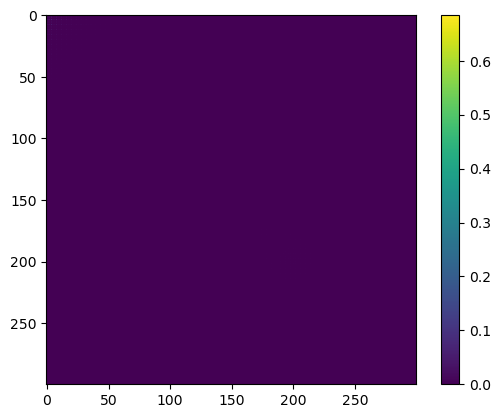

In [179]:
plt.imshow(np.real(density_matrix_two))
plt.colorbar()
print(np.trace(np.real(density_matrix_two)@get_photon_number_operator(n_signal)))

In [ ]:
print(np.trace(np.real(density_matrix_two)@get_photon_number_operator(n_signal)) + 2*np.trace(np.real(density_matrix_one)@get_photon_number_operator(n_pump)))

In [96]:
pump_photons1 = []
signal_photons1 = []
s0 = common_state_csr.toarray()
solutions[0] = s0
for i in tqdm(range(0, len(solutions), 1)):
    dec_sol_U, dec_sol_S, dec_sol_V = np.linalg.svd(solutions[i].reshape(n_pump, n_signal), full_matrices=False)
    
    density_matrix_one_fp = dec_sol_U @ np.diag(dec_sol_S) 
    density_matrix_one = density_matrix_one_fp @ np.conj(density_matrix_one_fp.T)
    
    density_matrix_two_fp = (np.diag(dec_sol_S) @ dec_sol_V).T 
    density_matrix_two = density_matrix_two_fp @ np.conj(density_matrix_two_fp.T)
    
    pump_photons1.append(np.trace(np.real(density_matrix_one)@get_photon_number_operator(n_pump)))
    signal_photons1.append(np.trace(np.real(density_matrix_two)@get_photon_number_operator(n_signal)))
    
ph_sum1 = 2*np.array(pump_photons1) + np.array(signal_photons1)

100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [09:11<00:00,  1.10s/it]


In [196]:
def calculate_photon_dynamics_in_set_of_solutions_in_Fock_b(solutions, n_pump, n_signal):
    pump_photons = []
    signal_photons = []
    for i in tqdm(range(0, len(solutions), 1)):
        dec_sol_U, dec_sol_S, dec_sol_V = np.linalg.svd(solutions[i].reshape(n_pump, n_signal), full_matrices=False)
        
        density_matrix_one_fp = dec_sol_U @ np.diag(dec_sol_S) 
        density_matrix_one = density_matrix_one_fp @ np.conj(density_matrix_one_fp.T)
        
        density_matrix_two_fp = (np.diag(dec_sol_S) @ dec_sol_V).T 
        density_matrix_two = density_matrix_two_fp @ np.conj(density_matrix_two_fp.T)
        
        pump_photons.append(np.trace(np.real(density_matrix_one)@get_photon_number_operator(n_pump)))
        signal_photons.append(np.trace(np.real(density_matrix_two)@get_photon_number_operator(n_signal)))    
    ph_sum = 2*np.array(pump_photons) + np.array(signal_photons)
    return pump_photons, signal_photons, ph_sum

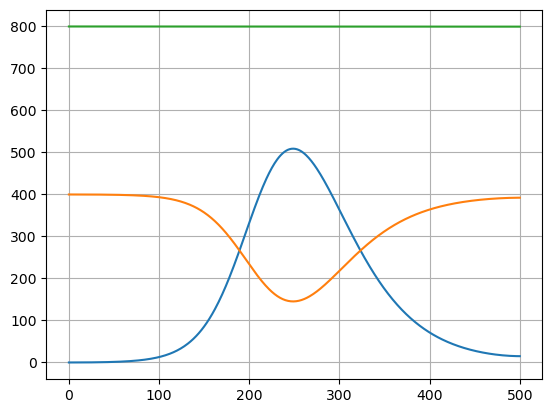

In [97]:
# plt.plot(signal_photons)
# plt.plot(pump_photons)
# plt.plot(ph_sum)

plt.plot(signal_photons1)
plt.plot(pump_photons1)
plt.plot(ph_sum1)

plt.grid()

### Перевод матрицы плотности из фоковского базиса в координатный

In [89]:
def hermit_pol(n, x):
    h0 = 1
    h1 = 2*x
    h = h0 * (1-n) + h1 * n
    if n > 1:
        return 2*x * hermit_pol(n-1, x) - 2*(n-1) * hermit_pol(n-2, x)
    else:
        return h

In [90]:
def hermit_pol_2(n, x):
    if n == 0:
        return 1
    elif n == 1:
        return 2 * x

    h0 = 1
    h1 = 2 * x
    for i in range(2, n + 1):
        h = 2 * x * h1 - 2 * (i - 1) * h0
        h0, h1 = h1, h

    return h1

In [189]:
def hermit_pol_3_comb(n, x):
    if n == 0:
        return 1 * np.exp(- x**2 / 2)
    elif n == 1:
        return 2 * x * np.exp(- x**2 / 2)

    h0 = 1
    h1 = 2 * x
    for i in range(2, n + 1):
        h = (2 * x * h1 - 2 * (i - 1) * h0)*(np.exp(- x**2 / 2))**(1/(n-1))
        h1 = h1 * (np.exp(- x**2 / 2))**(1/(n-1))
        h0, h1 = h1, h

    return h1

In [93]:
def psi_fock(n, x):
    return hermit_pol_2(n, x) * np.exp(- x**2 / 2) / np.sqrt(2**n * math.factorial(n) *np.sqrt(np.pi))

In [94]:
def psi_fock_2(n, x):
    # Calculate the logarithm of the factorial
    log_factorial_n = sum(np.log(np.arange(1, n + 1)))

    # Calculate the logarithm of the normalization factor
    log_norm = 0.5 * (n * np.log(2) + log_factorial_n + 0.5 * np.log(np.pi))

    # Calculate the Hermite polynomial
    hermite_value = hermit_pol_2(n, x)

    # Calculate the exponential part
    exp_value = np.exp(- x**2 / 2)

    # Combine the results
    result = hermite_value * exp_value / np.exp(log_norm)

    return result

In [190]:
def psi_fock_3(n, x):
    # Calculate the logarithm of the factorial
    log_factorial_n = sum(np.log(np.arange(1, n + 1)))

    # Calculate the logarithm of the normalization factor
    log_norm = 0.5 * (n * np.log(2) + log_factorial_n + 0.5 * np.log(np.pi))

    # Calculate the Hermite polynomial
    hermite_value = hermit_pol_3_comb(n, x)

    # Combine the results
    result = hermite_value / np.exp(log_norm)

    return result

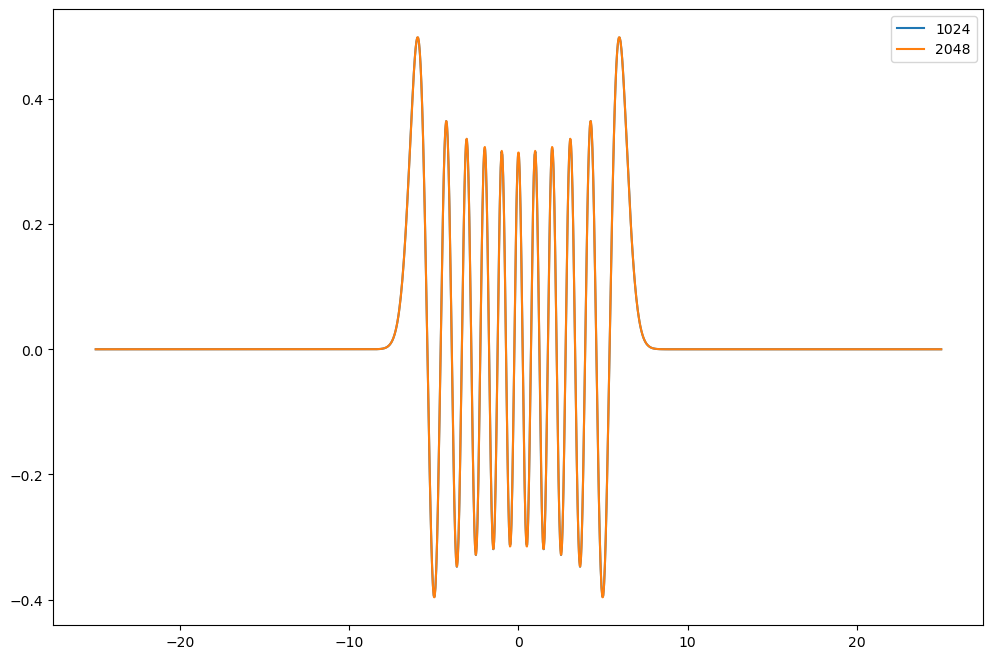

In [167]:
plt.figure(figsize = (12,8))
fock_state = 20
x_max = 25
points_num1 = 50
points_num2 = 100
points_num3 = 300
points_num4 = 500
points_num5 = 700
points_num6 = 900
points_num7 = 1024
points_num8 = 2048
#plt.plot(np.linspace(-x_max, x_max, points_num1), psi_fock_3(fock_state, np.linspace(-x_max, x_max, points_num1)), label = f"{points_num1}")
#plt.plot(np.linspace(-x_max, x_max, points_num2), psi_fock_3(fock_state, np.linspace(-x_max, x_max, points_num2)), label = f"{points_num2}")
#plt.plot(np.linspace(-x_max, x_max, points_num3), psi_fock_3(fock_state, np.linspace(-x_max, x_max, points_num3)), label = f"{points_num3}")
#plt.plot(np.linspace(-x_max, x_max, points_num4), psi_fock_3(fock_state, np.linspace(-x_max, x_max, points_num4)), label = f"{points_num4}")
#plt.plot(np.linspace(-x_max, x_max, points_num5), psi_fock_3(fock_state, np.linspace(-x_max, x_max, points_num5)), label = f"{points_num5}")
#plt.plot(np.linspace(-x_max, x_max, points_num6), psi_fock_3(fock_state, np.linspace(-x_max, x_max, points_num6)), label = f"{points_num6}")
plt.plot(np.linspace(-x_max, x_max, points_num7), psi_fock_3(fock_state, np.linspace(-x_max, x_max, points_num7)), label = f"{points_num7}")
plt.plot(np.linspace(-x_max, x_max, points_num8), psi_fock_3(fock_state, np.linspace(-x_max, x_max, points_num8)), label = f"{points_num8}")
#plt.xlim(-1,1)
plt.legend()

In [235]:
xx_pump_matrices = []
xx_sig_matrices = []
array_for_Fock_states = []
x = np.linspace(-10,10,256)
#x = -10 + np.arange(256)*(10 / 2**(8 - 1))
for i in range(260):
    array_for_Fock_states.append(psi_fock_3(i, x))
    
for i in tqdm(range(0, len(solutions), 10)):
    dec_sol_U, dec_sol_S, dec_sol_V = np.linalg.svd(solutions[i].reshape(n_pump, n_signal), full_matrices=False)
        
    #density_matrix_one_fp = dec_sol_U @ np.diag(dec_sol_S) 
    #density_matrix_one = density_matrix_one_fp @ np.conj(density_matrix_one_fp.T)
    #p_pump_mn = density_matrix_one[:200, :200]
    #rho_pump_xy = transform_dm_from_F_to_coord(p_pump_mn, np.linspace(-10*(1+np.sqrt(2)),10*(1+np.sqrt(2)),256))
        
    density_matrix_two_fp = (np.diag(dec_sol_S) @ dec_sol_V).T 
    density_matrix_two = density_matrix_two_fp @ np.conj(density_matrix_two_fp.T)
    p_sig_mn = density_matrix_two[:260, :260]
    rho_sig_xy = transform_dm_from_F_to_coord_precalc(p_sig_mn, array_for_Fock_states)

    #xx_pump_matrices.append(rho_pump_xy)
    xx_sig_matrices.append(rho_sig_xy)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [21:02<00:00, 24.75s/it]


In [105]:
def transform_dm_from_F_to_coord(p_mn, x):
    pho_coord = np.zeros((len(x), len(x)), dtype = np.complex128)
    for i in tqdm(range(len(p_mn))):
        for j in range(len(p_mn)):
            pho_coord += p_mn[i][j] * np.outer(psi_fock_3(i, x), np.conj(psi_fock_3(j, x))) 
    return pho_coord

In [113]:
def transform_dm_from_F_to_coord_precalc(p_mn, fock_states):
    pho_coord = np.zeros((len(x), len(x)), dtype = np.complex128)
    for i in range(len(p_mn)):
        for j in range(len(p_mn)):
            pho_coord += p_mn[i][j] * np.outer(fock_states[i], np.conj(fock_states[j])) 
    return pho_coord

In [143]:
dec_sol_U, dec_sol_S, dec_sol_V = np.linalg.svd(solutions[0].reshape(n_pump, n_signal), full_matrices=False)
    
density_matrix_one_fp = dec_sol_U @ np.diag(dec_sol_S) 
density_matrix_one = density_matrix_one_fp @ np.conj(density_matrix_one_fp.T)

density_matrix_two_fp = (np.diag(dec_sol_S) @ dec_sol_V).T 
density_matrix_two = density_matrix_two_fp @ np.conj(density_matrix_two_fp.T)

In [1]:
def compute_fidelity(rho1, rho2):
    return (np.trace(sqrtm(sqrtm(rho1)@rho2@sqrtm(rho1))))**2

In [5]:
with open('C:/Users/kaprn/Desktop/MPS_directory/TensorNetworks/Tests_of_spdc/Data_for_article/alpha_20_comparison/Selected_for_article/rho_matrices_ph_basis_3.pkl', 'rb') as f:
    rho_matrices_hp_basis = pickle.load(f)

In [7]:
with open('C:/Users/kaprn/Desktop/MPS_directory/TensorNetworks/Tests_of_spdc/Data_for_article/alpha_20_comparison/Selected_for_article/rho_matrices_tn_512x512.pkl', 'rb') as f:
    rho_matrices_tn = pickle.load(f)